# Fonduer applied to financial statement processing

#### Data download

We have downloaded about 2000 html files into a directory. The download was carried out through Ubuntu's command prompt with 'sudo wget <link>'

#### Creating postgresql

Also created a postgresql database called which doesnt have any files in it

#### Populating database (KBC initialization)
we need to create a schema within the postgresql database to store our files

In [1]:
import os
import sys
import logging
import psutil
import pickle
import pandas as pd
import numpy as np
from scipy import sparse
import math
#from personal_utils import gen_custom_marginals

%load_ext line_profiler
%load_ext memory_profiler

#ATTRIBUTE is the name of the database
PARALLEL = 32
ATTRIBUTE = "test_may_29" # 2,007 docs database
#ATTRIBUTE = "finance_may_small" # 50 docs database
conn_string = 'postgresql://localhost:5432/' + ATTRIBUTE

In [2]:
# Checking pickles
try:
    pickle_in = open("pickle.L_Train_full", "rb")
    pickled = True
except:
    pickled = False

#### Initiliazing fonduer KB

We first initialize a Meta object, which manages the connection to the database automatically, and enables us to save intermediate results.

In [3]:
from fonduer import Meta, init_logging

# Configure logging for Fonduer
init_logging(log_dir="logs")

session = Meta.init(conn_string).Session()

[2019-06-09 18:19:19,164][INFO] fonduer.meta:50 - Setting logging directory to: logs/2019-06-09_18-19-19
[2019-06-09 18:19:19,200][INFO] fonduer.meta:134 - Connecting user:None to localhost:5432/test_may_29
[2019-06-09 18:19:20,079][INFO] fonduer.meta:161 - Initializing the storage schema


#### parsing the docs

Next, we load the corpus of 10-Q's and transform them into the unified data model. Each doc is represented by an HTM file. The HTM file is parsed to create a robust unified data model with textual, structural, and tabular modality information. Note that since each document is independent of each other, we can parse the documents in parallel. We depend on PostgreSQL for this functionality.

HTMLDocPreprocessor(DocPreprocessor):A generator which processes an HTML file or directory of HTML files into a set of Document objects.
    
Next, we configure a Parser, which serves as our CorpusParser for PDF documents. We use spaCy as a preprocessing tool to split our documents into sentences and tokens.In addition, we can specify which modality information to include in the unified data model for each document. Below, we enable structural information, as well as lingual information, which uses [spaCy] to provide annotations such as part-of-speech tags and dependency parse structures for these sentences. Note that after the progress bar indicates the completion of the parsing process, some more time will pass until all objects have been inserted into the database.

*If you get an error that the path is wrong it may be that the files within the path are not html and so the command doesnt work

from fonduer.parser.preprocessors import HTMLDocPreprocessor
from fonduer.parser import Parser

docs_path = "/home/ubuntu/anaconda3/finance_test/finance_may_24"
doc_preprocessor = HTMLDocPreprocessor(docs_path)

corpus_parser = Parser(session, structural=True, lingual=True, parallelism=PARALLEL)
%time corpus_parser.apply(doc_preprocessor)

In [4]:
from fonduer.parser.models import Document, Sentence, Paragraph, Figure, Table, Context

print(f"Documents: {session.query(Document).count()}")
print(f"Sentences: {session.query(Sentence).count()}")
print(f"Paragraphs: {session.query(Paragraph).count()}")
print(f"Figures: {session.query(Figure).count()}")
print(f"Tables: {session.query(Table).count()}")
print(f"Context: {session.query(Table).count()}")

Documents: 2007
Sentences: 2956776
Paragraphs: 4391717
Figures: 2726
Tables: 291815
Context: 291815


###  Dividing the Corpus into Test and Train¶

We'll split the documents 80/10/10 into train/dev/test splits. Note that here we do this in a non-random order to preverse the consistency in the tutorial, and we reference the splits by 0/1/2 respectively.

In [5]:
from  sqlalchemy.sql.expression import func, select

docs = session.query(Document).all()
ld = len(docs)

train_docs = set()
dev_docs = set()
test_docs = set()
splits = (0.7, 0.85)
data = [(doc.name, doc) for doc in docs]
data.sort(key=lambda x: x[0])
for i, (doc_name, doc) in enumerate(data):
    if i < splits[0] * ld:
        train_docs.add(doc)
    elif i < splits[1] * ld:
        dev_docs.add(doc)
    else:
        test_docs.add(doc)
from pprint import pprint

#pprint([x.name for x in train_docs])
#pprint([x.name for x in dev_docs])
#pprint([x.name for x in test_docs])

### Mention extraction

In [6]:
from fonduer.candidates.models import mention_subclass
import re
from fonduer.utils.data_model_utils import *

period = mention_subclass("period")
revenue = mention_subclass("revenue")

In [7]:
from fonduer.candidates.matchers import DictionaryMatch, RegexMatchSpan

date_matcher = RegexMatchSpan(rgx=r'(January|February|March|April|May|June|July|August|September|October|November|December)(\s)(28|29|30|31)(,)', longest_match_only = False)

In [8]:
def mention_span_matches_integer(mention):
    potential_integer_string = mention.get_span()
    try:
        type(int(potential_integer_string[0])) == int
        return True
    except:
        return False

In [ ]:
def is_in_table(mention):
    if (mention.sentence.table != None): return True
    else: return False

In [ ]:
def no_whitespace(mention):
    tracker = True
    for letter in mention.get_span()[:]:
        if letter == ' ':
            tracker = False
            break
    return tracker

In [ ]:
def words_exclude(mention):
    exclude_words = ['cogs', 'COGS', 'cost', 'costs', 'Cost', 'Costs','net income', 
                     'other', 'Other','deferred', 'Deferred', 'unearned','Unearned']
    words_in_row = get_row_ngrams(mention)
    for item in words_in_row:
        if item in exclude_words:
            return False
    return True

In [ ]:
def row_has_revenue(mention):
    revenue_words = ['revenue','revenues', 'Revenue', 'Revenues', 'REVENUE', 'REVENUES',
                    'sales', 'Sales', 'SALES']
    words_in_row = get_row_ngrams(mention)
    for item in words_in_row:
        if item in revenue_words:
            return True
    return False

In [ ]:
def min_length(mention):
    if len(mention.get_span()[:]) <= 3:
        return False
    else:
        return True

In [ ]:
# need to check recall. Some real candidates are not being included. Maybe because of 'EndedMarch, 30' 
#in some case without recognizing March

from fonduer.candidates.matchers import LambdaFunctionMatcher, Intersect, Union

#Creating Common matchers
in_table_matcher = LambdaFunctionMatcher(func = is_in_table)

#Creating all revenue matchers
integer_matcher = LambdaFunctionMatcher(func = mention_span_matches_integer)
no_whitespace_matcher = LambdaFunctionMatcher(func = no_whitespace)
row_has_revenue_matcher = LambdaFunctionMatcher(func = row_has_revenue)
words_exclude_matcher = LambdaFunctionMatcher(func = words_exclude)
min_length_matcher = LambdaFunctionMatcher(func = min_length)
revenue_matcher = Intersect(integer_matcher, in_table_matcher, no_whitespace_matcher, 
                            row_has_revenue_matcher, words_exclude_matcher, min_length_matcher)


# Creating all period matchers
period_matcher = Intersect(date_matcher, in_table_matcher)

### Define a Mention's MentionSpace¶


In [ ]:
from fonduer.candidates import MentionNgrams

period_ngrams = MentionNgrams(n_max=6)
revenue_ngrams = MentionNgrams(n_max=1)

### Running Mention Extraction


In [ ]:
from fonduer.candidates import MentionExtractor


mention_extractor = MentionExtractor(
    session,
    [period, revenue],
    [period_ngrams, revenue_ngrams],
    [period_matcher, revenue_matcher],
    parallelism = PARALLEL
)

In [ ]:
from fonduer.candidates.models import Mention

mention_extractor.apply(docs, parallelism = PARALLEL)
num_periods = session.query(period).count()
num_revenues = session.query(revenue).count()
print(
    f"Total Mentions: {session.query(Mention).count()} ({num_periods} period, {num_revenues} revenue)"
)

### Throttlers

In [9]:
def final_throttler(c):
    return same_table(c)

## Candidate Extraction

In [10]:
from fonduer.candidates.models import candidate_subclass

period_revenue = candidate_subclass("period_revenue", [period, revenue])

In [11]:
from fonduer.candidates.models import candidate_subclass
from fonduer.candidates import CandidateExtractor
from IPython.core.debugger import set_trace

#set_trace()
candidate_extractor = CandidateExtractor(session, 
                                         [period_revenue],
                                         throttlers = [final_throttler],
                                         self_relations = False,
                                         nested_relations = False,
                                         symmetric_relations = True)


for i, docs in enumerate([train_docs, dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i, parallelism=PARALLEL)
    print(f"Number of Candidates in split={i}: {session.query(period_revenue).filter(period_revenue.split == i).count()}")


[2019-06-09 18:19:55,974][INFO] fonduer.candidates.candidates:125 - Clearing table period_revenue (split 0)
[2019-06-09 18:19:56,548][INFO] fonduer.utils.udf:54 - Running UDF...


[2019-06-09 18:20:20,200][INFO] fonduer.candidates.candidates:125 - Clearing table period_revenue (split 1)
[2019-06-09 18:20:20,311][INFO] fonduer.utils.udf:54 - Running UDF...



Number of Candidates in split=0: 12948


[2019-06-09 18:20:33,058][INFO] fonduer.candidates.candidates:125 - Clearing table period_revenue (split 2)
[2019-06-09 18:20:33,135][INFO] fonduer.utils.udf:54 - Running UDF...



Number of Candidates in split=1: 2529



Number of Candidates in split=2: 1740


In [12]:
train_cands = candidate_extractor.get_candidates(split = 0)
dev_cands = candidate_extractor.get_candidates(split = 1)
test_cands = candidate_extractor.get_candidates(split = 2)

### feauturizer

In [13]:
#if train_cands generates error such as 'period' doesn't have attribute ..., try [train_cands]
from fonduer.features import Featurizer
try:
    pickle_in = open("pickle.F_Train_full", "rb")
    #pickle_in = open("pickle.F_Train", "rb")
    F_train_dense = pickle.load(pickle_in)
    F_train = [sparse.csr_matrix(F_train_dense)]
except:
    featurizer = Featurizer(session, [period_revenue])
    %time featurizer.apply(split=0, train=True, parallelism=PARALLEL)
    %time F_train = featurizer.get_feature_matrices(train_cands)
print(F_train[0].shape)

(12948, 110096)


In [14]:
try:
    pickle_in = open("pickle.F_dev_full", "rb")
    #pickle_in = open("pickle.F_dev", "rb")
    F_dev_dense = pickle.load(pickle_in)
    F_dev = [sparse.csr_matrix(F_dev_dense)]
except:
    %time featurizer.apply(split=1, parallelism=PARALLEL)
    %time F_dev = featurizer.get_feature_matrices(dev_cands)
print(F_dev[0].shape)

(2529, 110096)


In [15]:
try:
    pickle_in = open("pickle.F_test_full", "rb")
    #pickle_in = open("pickle.F_test", "rb")
    F_test_dense = pickle.load(pickle_in)
    F_test = [sparse.csr_matrix(F_test_dense)]
except:
    %time featurizer.apply(split=2, parallelism=PARALLEL)
    %time F_test = featurizer.get_feature_matrices(test_cands)
print(F_test[0].shape)

(1740, 110096)


### labeling functions

LF are not immediate eliminators of candidates (as are throttlers). For labeling functions, there is a probabilistic analysis that determines which candidates are the most likely to be correct

In [16]:
ABSTAIN = 0
FALSE = 1
TRUE = 2

In [17]:
def LF_same_page(c):
    (period, revenue) = c
    if same_page(c): return TRUE
    else: ABSTAIN

def LF_vertical_align(c):
    (period, revenue) = c
    per = period.context.sentence
    rev = revenue.context.sentence
    if per.col_start <= rev.col_start and per.col_end >= rev.col_end: return TRUE
    else: return ABSTAIN

def LF_early_in_table(c):
    (period, revenue) = c
    per = period.context.sentence
    rev = revenue.context.sentence
    if per.row_start <= 3 and rev.row_start <= 12: return TRUE
    else: return ABSTAIN
    
def LF_period_bold(c):
    (period, revenue) = c
    per = period.context.sentence
    if "font-weight:bold" in per.html_attrs[0]: return TRUE
    else: return ABSTAIN 
        
def LF_common_ancestor(c):
    if common_ancestor(c) != None: return FALSE
    else: return ABSTAIN
    
def LF_lowest_common_ancestor_depth(c):
    if lowest_common_ancestor_depth(c) <= 3: return TRUE
    else: return ABSTAIN
    
def LF_near_row(c):
    (period, revenue) = c
    if revenue.context.sentence.row_start - period.context.sentence.row_start <= 10: return TRUE
    else: return ABSTAIN
    

def LF_header_not_date(c):
    (period, revenue) = c
    if not overlap(list(get_head_ngrams(mention = revenue, axis = 'col')), 
                   period.context.sentence.words): 
        return FALSE
    else: 
        return ABSTAIN

def LF_early_table(c):
    (period, revenue) = c
    per = period.context.sentence
    table_pos = per.table.position
    sentence_pos = per.position
    if table_pos > 0:
        ratio = sentence_pos / table_pos
        if table_pos <= 10 and ratio > 10:
            return TRUE
        else:
            return ABSTAIN


def LF_no_point(c):
    (period, revenue) = c
    if len(revenue.context.sentence.text[:]) < 5:
        for letter in revenue.context.sentence.text[:]:
            if letter == '.': 
                return FALSE
        return ABSTAIN
    return ABSTAIN


def LF_no_perc(c):
    (period, revenue) = c
    for letter in revenue.context.sentence.text[:]:
        if letter == '%': return FALSE
    return ABSTAIN

def LF_revenue_length(c):
    (period, revenue) = c
    has_dot = False
    for letter in revenue.context.sentence.text[:]:
        if letter == '.':
            has_dot = True
            
    if has_dot:
        if len(revenue.context.sentence.text[:]) <= 4:
            return FALSE
    else:
        if len(revenue.context.sentence.text[:]) <= 3:
            return FALSE
        elif type(revenue.context.sentence.text) == int:
            return FALSE
        
    return ABSTAIN
            
    
def LF_rev_not_like_year(c):
    (period, revenue) = c
    rev = revenue.context.sentence
    
    has_dot = False
    for letter in rev.text[:]:
        if letter == '.':
            has_dot = True
            break
        break
    
    try:
        fig = int(rev.text)
        if (fig == 2018 | fig == 2019 | fig == 2017) == True & has_dot == False:
            return FALSE
    except:
        return ABSTAIN
    return ABSTAIN

def LF_tot_revenues(c):
    
    (period, revenue) = c
    rev = revenue.context.sentence
    words_row = get_row_ngrams(revenue)
    
    total_words = ['total', 'Total', 'TOTAL']
    revenue_words = ['revenue','revenues', 'Revenue', 'Revenues', 'REVENUE', 'REVENUES',
                     'sales', 'Sales', 'SALES']
    
    if overlap(words_row, total_words) & overlap(words_row, revenue_words):
        return TRUE
    else:
        return ABSTAIN


In [18]:
def LF_PL_words(c):
    (period, revenue) = c
    
    cost_words = ['cost', 'costs']
    income_words = ['net', 'operating']
    share_words = ['share']
    expense_words = ['selling', 'administrative','general']
    tax_words = ['tax', 'taxes']
    
        
    #getting mention document and table data
    doc_id = revenue.context.sentence.document_id
    table_num = revenue.context.sentence.table_id
    
    #extracting all columns in the first sentence of that table
    sentences = session.query(Sentence).filter(Sentence.document_id == doc_id, 
                                               Sentence.table_id == table_num, 
                                               Sentence.col_start == 0).order_by(Sentence.position)

    #looking for specific words 
    c = 0
    for sentence in sentences:
        for word in sentence.words:
            if word.lower() in cost_words:
                c += 1
            if word.lower() in income_words:
                c += 0.5
            if word.lower() in share_words:
                c += 1
            if word.lower() in expense_words:
                c += 0.5
            if word.lower() in tax_words:
                c += 2

    if c >=4: return TRUE
    else: return ABSTAIN

def LF_big_table(c):
    (period, revenue) = c
    rev = revenue.context.sentence
    doc_id = rev.document_id
    table_num = rev.table_id
    row_num = rev.row_start
    
    sentences = session.query(Sentence).filter(Sentence.document_id == doc_id,
                                               Sentence.table_id == table_num,
                                               Sentence.col_start >= 0).order_by(Sentence.position)
    row = 0
    for sentence in sentences:
        row = sentence.row_start
        
    if row >= 20: return TRUE
    else: return ABSTAIN
    
    
def LF_revenue_max(c):
    (period, revenue) = c
    rev = revenue.context.sentence
    doc_id = rev.document_id
    table_num = rev.table_id
    row_num = rev.row_start
    col_beg = rev.col_start
    col_end = rev.col_end
    
    sentences = session.query(Sentence).filter(Sentence.document_id == doc_id,
                                               Sentence.table_id == table_num,
                                               Sentence.col_start >= 0,
                                               Sentence.col_start <= 1,
                                               Sentence.row_start >= row_num + 1,
                                               Sentence.row_start <= row_num + 5,
                                               Sentence.row_start != row_num).order_by(Sentence.position)
    
    revenue_words = ['revenue','revenues', 'Revenue', 'Revenues', 'REVENUE', 'REVENUES',
                    'sales', 'Sales', 'SALES']
    
    cost_words = ['cost', 'Cost', 'COST', 'costs', 'Costs', 'COSTS', 
                  'goods', 'Goods', 'GOODS' 'sold', 'Sold', 'SOLD']
    
    cost_count = 0
    revenue_count = 0
    
    for sentence in sentences:
        for word in sentence.words:
            #print(word)
            if word in revenue_words:
                revenue_count += 1
                #print('this is a revenue')
            elif word in cost_words:
                cost_count +=1
                #print('this is a cost')
     
    if cost_count >0 and revenue_count <= 1:
        return TRUE
    else:
        return ABSTAIN
 

        
def LF_note_word(c):
    (period, revenue) = c
    per = period.context.sentence
    doc_id = per.document_id
    table_num = per.table_id
    sentences = session.query(Sentence).filter(Sentence.document_id == doc_id, 
                                               Sentence.position <= per.position,
                                               Sentence.position >= per.position - 10).order_by(Sentence.position)
    
    note_words = ['note', 'Note', 'NOTE', 'notes', 'Notes', 'NOTES'] 

    for sentence in sentences:
        c = 0
        for word in sentence.words:
            if overlap(note_words, sentence.words):
                return FALSE
    return ABSTAIN

    
def LF_close_IS(c):
    (period, revenue) = c
    per = period.context.sentence
    doc_id = per.document_id
    table_num = per.table_id
    sentences = session.query(Sentence).filter(Sentence.document_id == doc_id, 
                                               Sentence.position < per.position,
                                               Sentence.position >= (per.position - 5)).order_by(Sentence.position)
    
    income_words = ['income', 'Income', 'INCOME', 
                    'operation', 'Operation', 'OPERATION', 'operations','Operations', 'OPERATIONS']
    statement_words = ['statement', 'Statement', 'STATEMENT', 'statements', 'Statements', 'STATEMENTS']
    
    for sentence in sentences:
        for word in sentence.words:
            if overlap(income_words, sentence.words) & overlap(statement_words, sentence.words):
                return TRUE
            else:
                return ABSTAIN

In [19]:
LF_parallel = [LF_vertical_align,
               LF_early_in_table,
               LF_near_row,
               LF_rev_not_like_year,
               LF_early_table,
               LF_no_point,
               LF_no_perc,
               LF_tot_revenues,
               LF_revenue_length]

In [20]:
LF_linear = [LF_PL_words,
             LF_big_table,
             LF_revenue_max,
             LF_note_word,
             LF_close_IS]

In [21]:
LFs = [LF_vertical_align,
       LF_early_in_table,
       LF_near_row,
       LF_rev_not_like_year,
       LF_early_table,
       LF_no_point,
       LF_no_perc,
       LF_tot_revenues,
       LF_revenue_length,
       LF_PL_words,
       LF_big_table,
       LF_revenue_max,
       LF_note_word,
       LF_close_IS]

In [22]:
LFCs = [LF_same_page, 
       LF_vertical_align,
       LF_early_in_table,
       LF_period_bold,
       LF_near_row,
       LF_PL_words,
       LF_rev_not_like_year,
       LF_big_table,
       LF_header_not_date,
       LF_early_table,
       LF_revenue_max,
       LF_note_word,
       LF_close_IS,
       LF_no_point,
       LF_revenue_length,
       LF_no_perc,
       LF_tot_revenues]

## Importing or creating labels for train set

In [23]:
from fonduer.supervision import Labeler
try:
    pickle_in = open("pickle.L_Train_full", "rb")
    #pickle_in = open("pickle.L_Train", "rb")
    L_train_dense = pickle.load(pickle_in)
    L_train = [sparse.csr_matrix(L_train_dense)]
    
except:
    try:
        labeler.clear()
        labeler = Labeler(session = session, candidate_classes = [period_revenue])
    except:
        labeler = Labeler(session = session, candidate_classes = [period_revenue])

    %time labeler.apply(split=0, lfs=[LF_parallel], train=True, clear=True, parallelism = PARALLEL)
    %time labeler.update(split=0, lfs=[LF_linear])
    %time L_train = labeler.get_label_matrices(train_cands)


from fonduer.supervision import Labeler

try:
    labeler.clear()
    labeler = Labeler(session = session, candidate_classes = [period_revenue])
except:
    labeler = Labeler(session = session, candidate_classes = [period_revenue])

%time labeler.apply(split=0, lfs=[LF_parallel], train=True, clear=True, parallelism = PARALLEL)
%time labeler.update(split=0, lfs=[LF_linear])
%time L_train = labeler.get_label_matrices(train_cands)


In [24]:
from metal import analysis

if pickled: analysis.lf_summary(L_train[0])
else: analysis.lf_summary(L_train[0], lf_names = labeler.get_keys())

## Creating Fonduer marginals

In [28]:
from metal.label_model import LabelModel

gen_model = LabelModel(k = 2)
#%time gen_model.train_model(L_train[0],n_epochs=500, print_every=100)
%time gen_model.train_model(L_train[0], class_balance = [0.8,0.2],n_epochs=500, print_every=100)

train_marginals = gen_model.predict_proba(L_train[0])

Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.969]
[2 epo]: TRAIN:[loss=1.915]
[3 epo]: TRAIN:[loss=1.811]
[4 epo]: TRAIN:[loss=1.664]
[5 epo]: TRAIN:[loss=1.480]
[6 epo]: TRAIN:[loss=1.268]
[7 epo]: TRAIN:[loss=1.038]
[8 epo]: TRAIN:[loss=0.803]
[9 epo]: TRAIN:[loss=0.583]
[10 epo]: TRAIN:[loss=0.397]
[11 epo]: TRAIN:[loss=0.265]
[12 epo]: TRAIN:[loss=0.200]
[13 epo]: TRAIN:[loss=0.203]
[14 epo]: TRAIN:[loss=0.258]
[15 epo]: TRAIN:[loss=0.337]
[16 epo]: TRAIN:[loss=0.405]
[17 epo]: TRAIN:[loss=0.434]
[18 epo]: TRAIN:[loss=0.416]
[19 epo]: TRAIN:[loss=0.361]
[20 epo]: TRAIN:[loss=0.290]
[21 epo]: TRAIN:[loss=0.223]
[22 epo]: TRAIN:[loss=0.176]
[23 epo]: TRAIN:[loss=0.153]
[24 epo]: TRAIN:[loss=0.151]
[25 epo]: TRAIN:[loss=0.162]
[26 epo]: TRAIN:[loss=0.180]
[27 epo]: TRAIN:[loss=0.196]
[28 epo]: TRAIN:[loss=0.207]
[29 epo]: TRAIN:[loss=0.210]
[30 epo]: TRAIN:[loss=0.203]
[31 epo]: TRAIN:[loss=0.190]
[32 epo]: TRAIN:[loss=0.172]
[33 epo]: TRAIN:[loss=0.151]
[34 epo]: TRAIN:[lo

[331 epo]: TRAIN:[loss=0.026]
[332 epo]: TRAIN:[loss=0.026]
[333 epo]: TRAIN:[loss=0.026]
[334 epo]: TRAIN:[loss=0.026]
[335 epo]: TRAIN:[loss=0.026]
[336 epo]: TRAIN:[loss=0.026]
[337 epo]: TRAIN:[loss=0.026]
[338 epo]: TRAIN:[loss=0.026]
[339 epo]: TRAIN:[loss=0.026]
[340 epo]: TRAIN:[loss=0.026]
[341 epo]: TRAIN:[loss=0.026]
[342 epo]: TRAIN:[loss=0.026]
[343 epo]: TRAIN:[loss=0.026]
[344 epo]: TRAIN:[loss=0.026]
[345 epo]: TRAIN:[loss=0.026]
[346 epo]: TRAIN:[loss=0.026]
[347 epo]: TRAIN:[loss=0.026]
[348 epo]: TRAIN:[loss=0.026]
[349 epo]: TRAIN:[loss=0.026]
[350 epo]: TRAIN:[loss=0.026]
[351 epo]: TRAIN:[loss=0.026]
[352 epo]: TRAIN:[loss=0.026]
[353 epo]: TRAIN:[loss=0.026]
[354 epo]: TRAIN:[loss=0.026]
[355 epo]: TRAIN:[loss=0.026]
[356 epo]: TRAIN:[loss=0.026]
[357 epo]: TRAIN:[loss=0.026]
[358 epo]: TRAIN:[loss=0.026]
[359 epo]: TRAIN:[loss=0.026]
[360 epo]: TRAIN:[loss=0.026]
[361 epo]: TRAIN:[loss=0.026]
[362 epo]: TRAIN:[loss=0.026]
[363 epo]: TRAIN:[loss=0.026]
[364 epo]:

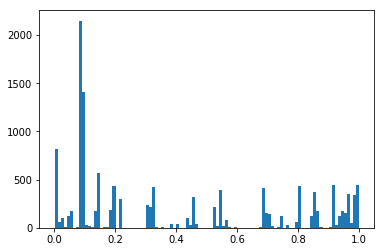

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(train_marginals[:, 1], bins=100)
plt.show()

## Creating custom marginals

In [27]:
label_funcs_train_set = {}
train_set_LFs = L_train[0].toarray()
if pickled: label_names = [i for i in range(L_train[0].shape[1])]
else: label_names = labeler.get_keys()
for i in range(train_set_LFs.shape[1]):
    label_funcs_train_set[label_names[i]] = train_set_LFs[:,i]
    
period = []
revenue = []
doc = []
table = []

for i in range(len(train_cands[0])):
    period.append(train_cands[0][i].period.context.get_span())
    revenue.append(train_cands[0][i].revenue.context.get_span())
    doc.append(train_cands[0][i].revenue.context.sentence.document)
    table.append(train_cands[0][i].revenue.context.sentence.table.position)

results_train = np.c_[period, revenue, doc, table, train_marginals[:,1]]
results_train = pd.DataFrame(results_train)
results_train.columns=['period', 'revenue', 'doc', 'table', 'probability']
for lf, labeling in label_funcs_train_set.items():
    results_train[lf] = labeling

In [28]:
train_marginals_custom, results_train_2 = gen_custom_marginals(results_train)
print(train_marginals_custom)
#results_train_2.to_csv('lf_analysis_train_set2.csv')

[[0.83928289 0.16071711]
 [0.54479539 0.45520461]
 [0.83928289 0.16071711]
 ...
 [0.07236924 0.92763076]
 [0.07236924 0.92763076]
 [0.07236924 0.92763076]]


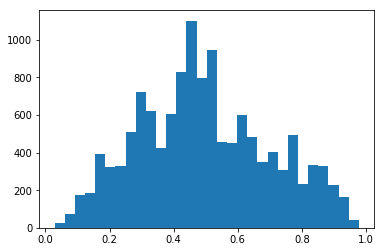

In [29]:
%matplotlib inline

plt.hist(train_marginals_custom[:, 1], bins=30)
plt.show()

## Creating models

In [ ]:
train_marginals_custom_df = pd.DataFrame(train_marginals_custom)
train_marginals_custom_df.to_csv('train_margs.csv')

In [61]:
%reload_ext autoreload
%aimport fonduer.learning
%aimport fonduer.utils
%autoreload 1

import torch
import fonduer.learning
from fonduer.learning import LogisticRegression
from fonduer.learning import LSTM
from fonduer.learning import NeuralNet

torch.set_num_threads(PARALLEL)
print(torch.get_num_threads())

print(torch.cuda.device_count())

#neural = NeuralNet(structure = [200, 20], F = F_train[0])
#if torch.cuda.device_count() > 1:
#  print("Let's use", torch.cuda.device_count(), "GPUs!")
#  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#  neural = nn.DataParallel(neural)

#model.to(device)

neural2 = NeuralNet(structure = [200, 20], F = F_train[0])
%time neural2.train((train_cands[0], F_train[0]), train_marginals, n_epochs = 1, batch_size = 64, lr = 0.00001, print_freq = 1, host_device = "GPU")

32
8


[2019-06-09 20:56:32,592][INFO] fonduer.learning.classifier:117 - Loading default parameters for Logistic Regression
[2019-06-09 20:56:45,627][INFO] fonduer.learning.classifier:213 - Using GPU...
[2019-06-09 20:56:45,627][INFO] fonduer.learning.classifier:215 - Settings: {'log_dir': 'logs/2019-06-09_18-19-19/2019-06-09_20-56-32_NeuralNet', 'n_epochs': 1, 'lr': 1e-05, 'batch_size': 64, 'shuffle': True, 'seed': 1234, 'host_device': 'GPU', 'bias': False, 'input_dim': 110096}
[2019-06-09 20:56:45,648][INFO] fonduer.learning.classifier:233 - [NeuralNet] Training model
[2019-06-09 20:56:45,649][INFO] fonduer.learning.classifier:235 - [NeuralNet] n_train=12948 #epochs=1 batch size=64
[2019-06-09 21:00:05,215][INFO] fonduer.learning.classifier:289 - [NeuralNet] Epoch 1 (199.57s)	Average loss=0.705992
[2019-06-09 21:00:05,350][INFO] fonduer.learning.classifier:516 - [NeuralNet] Model saved as checkpoint_epoch_1.pt in logs/2019-06-09_18-19-19/2019-06-09_20-56-32_NeuralNet
[2019-06-09 21:00:05,35

CPU times: user 3min 9s, sys: 25.9 s, total: 3min 34s
Wall time: 3min 33s


## Using the Model to Iterate on Labeling Functions on the dev/train set¶

In [39]:
try:
    pickle_in = open("pickle.L_Dev_full", "rb")
    L_dev_dense = pickle.load(pickle_in)

    pickle_in = open("pickle.L_Test_full", "rb")
    L_test_dense = pickle.load(pickle_in)

    L_dev = [sparse.csr_matrix(L_dev_dense)]
    L_test = [sparse.csr_matrix(L_test_dense)]
    
except:
    
    labeler.apply(split=1, lfs=[LFs])
    %time L_dev = labeler.get_label_matrices(dev_cands)

    labeler.apply(split=2, lfs=[LFs])
    %time L_test = labeler.get_label_matrices(test_cands)

labeler.apply(split=1, lfs=[LFs])
%time L_dev = labeler.get_label_matrices(dev_cands)

labeler.apply(split=2, lfs=[LFs])
%time L_test = labeler.get_label_matrices(test_cands)

In [40]:
label_funcs_dev_set = {}
dev_set_LFs = L_dev[0].toarray()
#label_names = labeler.get_keys()
label_names = [i for i in range(L_dev[0].shape[1])]
for i in range(dev_set_LFs.shape[1]):
    label_funcs_dev_set[label_names[i]] = dev_set_LFs[:,i]
    
label_funcs_test_set = {}
test_set_LFs = L_test[0].toarray()
#label_names = labeler.get_keys()
label_names = [i for i in range(L_test[0].shape[1])]
for i in range(test_set_LFs.shape[1]):
    label_funcs_test_set[label_names[i]] = test_set_LFs[:,i]

## Running predictions

In [41]:
#testing dev and test set results
dev_score = neural2.predict((dev_cands[0], F_dev[0]), b = 0.4, pos_label = TRUE, return_probs=True)
test_score = neural2.predict((test_cands[0], F_test[0]), b = 0.4, pos_label = TRUE, return_probs=True)

[2019-06-09 19:50:30,792][INFO] fonduer.learning.classifier:403 - Using positive label class 2 with threshold 0.4
[2019-06-09 19:50:55,483][INFO] fonduer.learning.classifier:403 - Using positive label class 2 with threshold 0.4


In [42]:
import numpy as np

#dev_set numbers
count = 0
for i in dev_score[0]:
    if i == 2:
        count += 1
print('dev positive count: ' + str(count))

#test_set numbers
count = 0
for i in test_score[0]:
    if i == 2:
        count += 1
print('test positive count: ' + str(count))

dev positive count: 1248
test positive count: 942


In [43]:
len(dev_cands[0])

2529

In [44]:

# updating results_train
results_train.rename(columns={0:'temp'}, inplace=True)
results_train = extract_cik(results_train)
results_train.rename(columns={'temp':0}, inplace=True)

#pending add albeling functions results here

period = []
revenue = []
doc = []
table = []

for i in range(len(dev_cands[0])):
    period.append(dev_cands[0][i].period.context.get_span())
    revenue.append(dev_cands[0][i].revenue.context.get_span())
    doc.append(dev_cands[0][i].revenue.context.sentence.document)
    table.append(dev_cands[0][i].revenue.context.sentence.table.position)

results_dev = np.c_[period, revenue, doc, table, dev_score[0], dev_score[1][:,1]]
results_dev = pd.DataFrame(results_dev)
results_dev.columns=['period', 'revenue', 'doc', 'table', 'dev_score', 'probability']
for lf, labeling in label_funcs_dev_set.items():
    results_dev[lf] = labeling
results_dev.rename(columns={0:'temp'}, inplace=True)
results_dev = extract_cik(results_dev)
results_dev.rename(columns={'temp':0}, inplace=True)
    
period = []
revenue = []
doc = []
table = []

for i in range(len(test_cands[0])):
    period.append(test_cands[0][i].period.context.get_span())
    revenue.append(test_cands[0][i].revenue.context.get_span())
    doc.append(test_cands[0][i].revenue.context.sentence.document)
    table.append(test_cands[0][i].revenue.context.sentence.table.position)

results_test = np.c_[period, revenue, doc, table, test_score[0], test_score[1][:,1]]
results_test = pd.DataFrame(results_test)
results_test.columns=['period', 'revenue', 'doc', 'table', 'test_score', 'probability']
for lf, labeling in label_funcs_test_set.items():
    results_test[lf] = labeling
results_test.rename(columns={0:'temp'}, inplace=True)
results_test = extract_cik(results_test)
results_test.rename(columns={'temp':0}, inplace=True)

In [45]:
results_train.to_csv('results_train0.csv')
results_dev.to_csv('results_dev0.csv')
results_test.to_csv('results_test0.csv')

### Computing errors

In [46]:
y_dev_results_path = "/home/ubuntu/anaconda3/results_dev0.csv"
results_dev2 = pd.read_csv(y_dev_results_path)
#results_dev2 = results_dev
del results_dev2['Unnamed: 0']
results_dev2['revenue_string'] = results_dev2['revenue'].astype(str)

y_dev_path = "/home/ubuntu/anaconda3/Y_final.csv"
y_dev = pd.read_csv(y_dev_path)
y_dev['Revenue_string'] = y_dev['Revenue'].astype(str)
y_dev['True_label'] = 2
del y_dev['Unnamed: 0']

In [47]:
Results_dev = results_dev2.merge(y_dev, left_on=['CIK','revenue_string'], right_on=['CIK','Revenue_string'], how='left')
Results_dev = Results_dev[['period', 'revenue', 'doc', 'table', 'probability', 'True_label']]
Results_dev = Results_dev.fillna(1)

Results_dev = Results_dev.sort_values(['doc', 'probability'], ascending=[1, 0])

In [48]:
Aux = []
Aux.append(1)
dev_score = []

for i in range(1, len(Results_dev)):
    if Results_dev['doc'][i] == Results_dev['doc'][i-1]:
        Aux.append(Aux[i-1]+1)
    else:
        Aux.append(1)

for i in range(1, len(Aux)):
    if Aux[i] in range(1, 10):
        dev_score.append(2)
    else:
        dev_score.append(1)
dev_score.append(1)

dev_score = pd.DataFrame(dev_score)        
Results_dev = pd.concat([Results_dev, dev_score], axis=1)
Results_dev.rename(columns={0:'dev_score'}, inplace=True)

In [49]:
TP = []
TN = []
FP = []
FN = []

for i in range(len(Results_dev)):
    if Results_dev['True_label'][i] == 2:
        if Results_dev['dev_score'][i] == 2:
            TP.append(1)
            TN.append(0)
            FP.append(0)
            FN.append(0)
        else:
            TP.append(0)
            TN.append(0)
            FP.append(0)
            FN.append(1)
    else:
        if Results_dev['dev_score'][i] == 2:
            TP.append(0)
            TN.append(0)
            FP.append(1)
            FN.append(0)
        else:
            TP.append(0)
            TN.append(1)
            FP.append(0)
            FN.append(0)

TP = pd.DataFrame(TP)
TN = pd.DataFrame(TN)
FP = pd.DataFrame(FP)
FN = pd.DataFrame(FN)
Results_dev = pd.concat([Results_dev, TP, TN, FP, FN], axis=1)
Results_dev.columns = ['period','revenue','doc','table','probability','True_label','dev_score','TP','TN','FP','FN']

In [50]:
TP = 0
TN = 0
FP = 0
FN = 0

TP = Results_dev['TP'].sum()
TN = Results_dev['TN'].sum()
FP = Results_dev['FP'].sum()
FN = Results_dev['FN'].sum()

Accuracy = (TP+TN)/len(Results_dev)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
F1 = 2*(Recall * Precision) / (Recall + Precision)

print("The accuracy in the development set is %.1f%%" % (100*Accuracy))
print("The precision in the development set is %.1f%%" % (100*Precision))
print("The recall in the development set is %.1f%%" % (100*Recall))
print("The F1 score in the development set is %.1f%%" % (100*F1))

The accuracy in the development set is 31.9%
The precision in the development set is 24.1%
The recall in the development set is 93.9%
The F1 score in the development set is 38.4%


In [51]:
y_test_results_path = "/home/ubuntu/anaconda3/results_test0.csv"
#y_test_results_path = "/home/ubuntu/anaconda3/results_test_small.csv"
results_test2 = pd.read_csv(y_test_results_path)
del results_test2['Unnamed: 0']
results_test2['revenue_string'] = results_test2['revenue'].astype(str)

y_test_path = "/home/ubuntu/anaconda3/Y_final.csv"
y_test = pd.read_csv(y_test_path)
y_test['Revenue_string'] = y_test['Revenue'].astype(str)
y_test['True_label'] = 2
del y_test['Unnamed: 0']

In [52]:
Results_test = results_test2.merge(y_test, left_on=['CIK','revenue_string'], right_on=['CIK','Revenue_string'], how='left')
Results_test = Results_test[['period', 'revenue', 'doc', 'table', 'probability', 'True_label']]
Results_test = Results_test.fillna(1)

Results_test = Results_test.sort_values(['doc', 'probability'], ascending=[1, 0])

In [53]:
Aux = []
Aux.append(1)
test_score = []

for i in range(1, len(Results_test)):
    if Results_test['doc'][i] == Results_test['doc'][i-1]:
        Aux.append(Aux[i-1]+1)
    else:
        Aux.append(1)

for i in range(1, len(Aux)):
    if Aux[i] in range(1, 10):
        test_score.append(2)
    else:
        test_score.append(1)
test_score.append(1)

test_score = pd.DataFrame(test_score)        
Results_test = pd.concat([Results_test, test_score], axis=1)
Results_test.rename(columns={0:'test_score'}, inplace=True)

In [54]:
TP = []
TN = []
FP = []
FN = []

for i in range(len(Results_test)):
    if Results_test['True_label'][i] == 2:
        if Results_test['test_score'][i] == 2:
            TP.append(1)
            TN.append(0)
            FP.append(0)
            FN.append(0)
        else:
            TP.append(0)
            TN.append(0)
            FP.append(0)
            FN.append(1)
    else:
        if Results_test['test_score'][i] == 2:
            TP.append(0)
            TN.append(0)
            FP.append(1)
            FN.append(0)
        else:
            TP.append(0)
            TN.append(1)
            FP.append(0)
            FN.append(0)

TP = pd.DataFrame(TP)
TN = pd.DataFrame(TN)
FP = pd.DataFrame(FP)
FN = pd.DataFrame(FN)
Results_test = pd.concat([Results_test, TP, TN, FP, FN], axis=1)
Results_test.columns = ['period','revenue','doc','table','probability','True_label','test_score','TP','TN','FP','FN']

In [55]:
TP = Results_test['TP'].sum()
TN = Results_test['TN'].sum()
FP = Results_test['FP'].sum()
FN = Results_test['FN'].sum()

Accuracy = (TP+TN)/len(Results_test)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
F1 = 2*(Recall * Precision) / (Recall + Precision)

print("The accuracy in the test set is %.1f%%" % (100*Accuracy))
print("The precision in the test set is %.1f%%" % (100*Precision))
print("The recall in the test set is %.1f%%" % (100*Recall))
print("The F1 score in the test set is %.1f%%" % (100*F1))

The accuracy in the test set is 30.1%
The precision in the test set is 26.1%
The recall in the test set is 87.0%
The F1 score in the test set is 40.1%


### Train calculations

In [56]:
y_train_results_path = "/home/ubuntu/anaconda3/results_train0.csv"
results_train2 = pd.read_csv(y_train_results_path)
#results_dev2 = results_dev
del results_train2['Unnamed: 0']
results_train2['revenue_string'] = results_train2['revenue'].astype(str)

y_train_path = "/home/ubuntu/anaconda3/Y_final.csv"
y_train = pd.read_csv(y_train_path)
y_train['Revenue_string'] = y_train['Revenue'].astype(str)
y_train['True_label'] = 2
del y_train['Unnamed: 0']

In [57]:
Results_train = results_train2.merge(y_train, left_on=['CIK','revenue_string'], right_on=['CIK','Revenue_string'], how='left')
Results_train = Results_train[['period', 'revenue', 'doc', 'table', 'probability', 'True_label']]
Results_train = Results_train.fillna(1)

Results_train = Results_train.sort_values(['doc', 'probability'], ascending=[1, 0])

In [58]:
Aux = []
Aux.append(1)
train_score = []

for i in range(1, len(Results_train)):
    if Results_train['doc'][i] == Results_train['doc'][i-1]:
        Aux.append(Aux[i-1]+1)
    else:
        Aux.append(1)

for i in range(1, len(Aux)):
    if Aux[i] in range(1, 10):
        train_score.append(2)
    else:
        train_score.append(1)
train_score.append(1)

train_score = pd.DataFrame(train_score)        
Results_train = pd.concat([Results_train, train_score], axis=1)
Results_train.rename(columns={0:'train_score'}, inplace=True)

In [59]:
TP = []
TN = []
FP = []
FN = []

for i in range(len(Results_train)):
    if Results_train['True_label'][i] == 2:
        if Results_train['train_score'][i] == 2:
            TP.append(1)
            TN.append(0)
            FP.append(0)
            FN.append(0)
        else:
            TP.append(0)
            TN.append(0)
            FP.append(0)
            FN.append(1)
    else:
        if Results_train['train_score'][i] == 2:
            TP.append(0)
            TN.append(0)
            FP.append(1)
            FN.append(0)
        else:
            TP.append(0)
            TN.append(1)
            FP.append(0)
            FN.append(0)

TP = pd.DataFrame(TP)
TN = pd.DataFrame(TN)
FP = pd.DataFrame(FP)
FN = pd.DataFrame(FN)
Results_train = pd.concat([Results_train, TP, TN, FP, FN], axis=1)
Results_train.columns = ['period','revenue','doc','table','probability','True_label','train_score','TP','TN','FP','FN']

In [60]:
TP = Results_train['TP'].sum()
TN = Results_train['TN'].sum()
FP = Results_train['FP'].sum()
FN = Results_train['FN'].sum()

Accuracy = (TP+TN)/len(Results_train)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
F1 = 2*(Recall * Precision) / (Recall + Precision)

print("The accuracy in the train set is %.1f%%" % (100*Accuracy))
print("The precision in the train set is %.1f%%" % (100*Precision))
print("The recall in the train set is %.1f%%" % (100*Recall))
print("The F1 score in the train set is %.1f%%" % (100*F1))

The accuracy in the train set is 26.4%
The precision in the train set is 24.5%
The recall in the train set is 98.3%
The F1 score in the train set is 39.2%


## Pickling

In [ ]:
L_train_dense = L_train[0].todense()

pickle_out = open("pickle.L_Train_full","wb")
pickle.dump(L_train_dense, pickle_out, protocol=4)
pickle_out.close()

In [ ]:
L_dev_dense = L_dev[0].todense()

pickle_out = open("pickle.L_Dev_full","wb")
pickle.dump(L_dev_dense, pickle_out, protocol=4)
pickle_out.close()

In [ ]:
L_test_dense = L_test[0].todense()

pickle_out = open("pickle.L_Test_full","wb")
pickle.dump(L_test_dense, pickle_out, protocol=4)
pickle_out.close()

In [ ]:
F_train_dense = F_train[0].todense()

pickle_out = open("pickle.F_Train_full","wb")
pickle.dump(F_train_dense, pickle_out, protocol=4)
pickle_out.close()

In [ ]:
F_dev_dense = F_dev[0].todense()

pickle_out = open("pickle.F_dev_full","wb")
pickle.dump(F_dev_dense, pickle_out, protocol=4)
pickle_out.close()

In [ ]:
F_test_dense = F_test[0].todense()

pickle_out = open("pickle.F_test_full","wb")
pickle.dump(F_test_dense, pickle_out, protocol=4)
pickle_out.close()

In [37]:
def gen_custom_marginals(results_pandas):

    cols = list(results_pandas)
    results_pandas['score'] = 0
    results_pandas['prob'] = 0
    LF_names = cols[5:(len(cols)-1)]
    doc_names = results_pandas.doc.unique()

    for col in LF_names:
        for row in range(len(results_pandas)):
            if results_pandas[col][row] == 2: 
                results_pandas.loc[row, 'score'] += 1
            elif results_pandas[col][row] == 1:
                results_pandas.loc[row, 'score'] -= 1


    #calculating means
    totals = {}
    count = {}
    means = {}

    for row in range(len(results_pandas)):
        doc = results_pandas['doc'][row]
        if doc in totals:
            totals[doc] += results_pandas['score'][row]
            count[doc] += 1
        else:
            totals[doc] = results_pandas['score'][row]
            count[doc] = 1

    for doc in doc_names:
        means[doc] = totals[doc] / count[doc]


    #calculating stdevs
    stdev = {}

    for row in range(len(results_pandas)):
        doc = results_pandas['doc'][row]
        if doc in stdev:
            stdev[doc] += (results_pandas['score'][row] - means[doc])**2
        else:
            stdev[doc] = (results_pandas['score'][row] - means[doc])**2

    for doc in doc_names:
        stdev[doc] = math.sqrt(stdev[doc] / count[doc])

    #calculating probabilities
    for row in range(len(results_pandas)):
        doc = results_pandas['doc'][row]
        if stdev[doc] == 0:
            results_pandas.loc[row, 'prob'] = 0.5
        else:
            intermediate = (results_pandas['score'][row] - means[doc]) / stdev[doc]
            results_pandas.loc[row, 'prob'] = 1 / (1 + np.exp(-intermediate))
    
    results_pandas.fillna(0.5)
    probs = results_pandas['prob'].values
    probs = np.reshape(probs, (probs.shape[0],1))
    probs_1 = 1 - results_pandas['prob'].values
    probs_1 = np.reshape(probs_1, (probs_1.shape[0],1))
    new_marginals = np.concatenate((probs_1, probs), axis = 1)
    
    return new_marginals, results_pandas

In [38]:
def extract_cik(pandas_df):
    
    documents = pandas_df['doc']
    cik_list = [0] * len(documents)
    i = 0 
    Aux = []
    
    for doc in documents:
        document_name = doc.name
        count_lowdash = 0
        count_word = 0
        cik =''
        for  letter in document_name:
            count_word += 1
            if letter == "_": count_lowdash += 1
            if count_word >= 10 & count_lowdash == 0:
                cik = cik + letter
        cik = cik[:-5]
        Aux.append(cik)
        i += 1
        
    Aux = pd.DataFrame(Aux)        
    pandas_df = pd.concat([pandas_df, Aux], axis=1)
    pandas_df.rename(columns={0:'CIK'}, inplace=True)
        
    return pandas_df
            
        